In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_nw

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

options = {
    'node_color': 'lightgray',
    'node_size': 1000,
    'width': 2,
    'arrowstyle': '-|>',
    'arrowsize': 20,
    'font_size' : 20,
    'font_weight' : 'bold',
    }

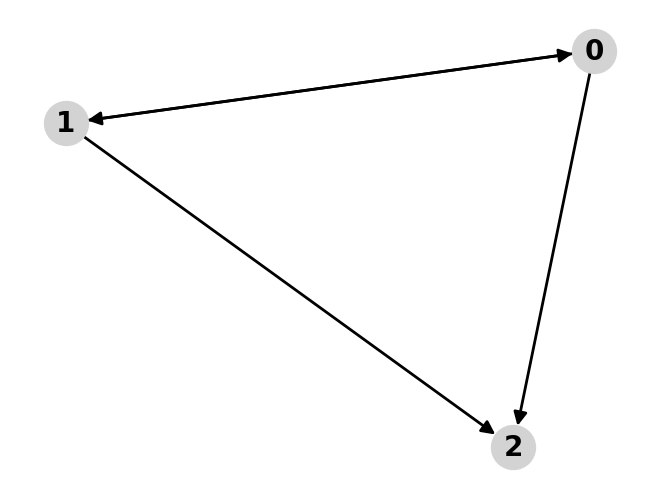

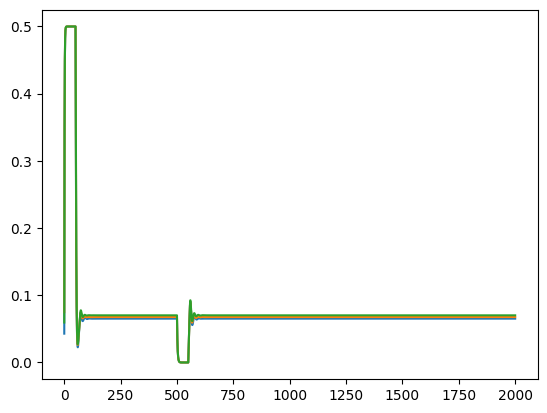

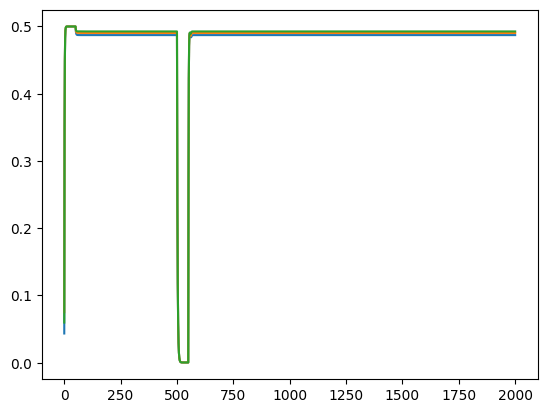

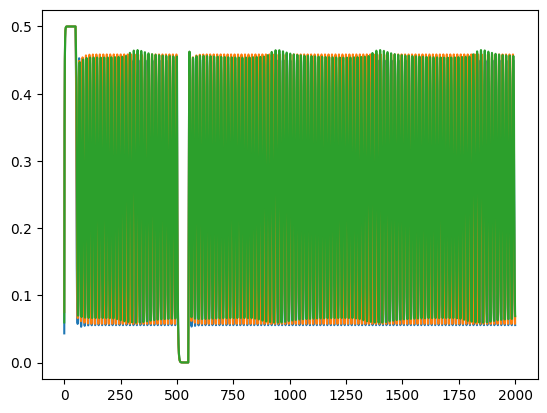

period =  15.43157894736842


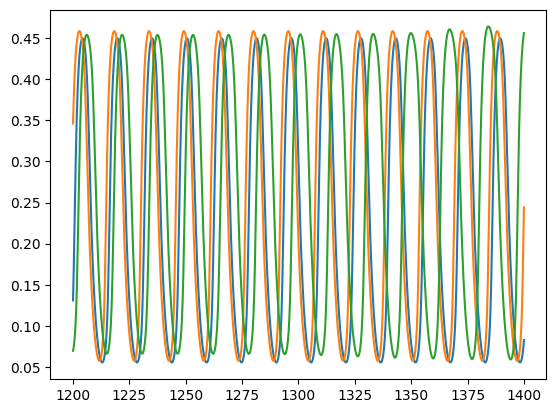

In [3]:
comp_points = [[1., 0.5], [3., 0.5], [2., 0.5]]

cmat = np.array( [[0., 0.5, 0.], [1., 0., 0.], [1., 0.5, 0.]] ) # diagonal elements are zero, connection strength is 1 from node 0 to node 1
dmat = np.array( [[0., 12., 0.], [10., 0., 0.], [10., 4., 0.]] ) # delay from 0 to 1

N = cmat.shape[0]
dir = "images_3n"

G = nx.DiGraph() 
for n in range(cmat.shape[0]):
        for l in range(cmat.shape[1]):
            if cmat[n,l] != 0:
                G.add_edge(l,n)
nx.draw(G, with_labels=True, arrows=True, **options)
plt.savefig(os.path.join(dir, "network.png"), bbox_inches='tight')
plt.show()


colors = []
n = 0
for col in mcolors.TABLEAU_COLORS:
    colors.append(col)
    n += 1
    if n >= N: break

model = WCModel(Cmat=cmat, Dmat=dmat)

dt = 0.1
model.params['dt'] = dt # Integration time step, ms
model.params['duration'] = 1. * 2000 # Simulation time, ms
model.params.signalV = 1.

zero_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
rect_input = np.vstack( (zero_input)*2 )
rect_input[0,:500] = 5.
rect_input[0,5000:5500] = -5.

for p in comp_points:
    model.params["exc_ext"] = p[0] + rect_input[0,:]
    model.params["inh_ext"] = p[1]
    model.run()

    for n in range(N):
        plt.plot(model.t, model.exc[n,:], color=colors[n])
    plt.show()

    if p[0] == 2.:

        peaks = scipy.signal.find_peaks(model.exc[0,2000:5000])[0]
        plist = []
        for pind in range(1, len(peaks)):
            plist.append(model.params.dt * (peaks[pind]-peaks[pind-1]))

        period = np.mean(plist)
        print("period = ", period)

        peaksn = [None]*N

        for n in range(N):
            peaksn[n] = scipy.signal.find_peaks(model.exc[n,4000:5000])[0]

        for n in range(N):
            plt.plot(model.t[12000:14000], model.exc[n,12000:14000], color=colors[n])
        plt.show()


In [26]:
def getperiods(x, prominence, int0=None):
    timing_list = [None] * N
    periods_list = [None] * N

    if int0 is None:
        int0 = 300

    for n in range(N):
        timing_list[n] = scipy.signal.find_peaks(x[n, 0, int0:], prominence=prominence)[0]
        periods_list[n] = []
        if len(timing_list[n]) < 3:
            continue
        for pind in range(1, len(timing_list[n])):
            periods_list[n].append(model.params.dt * (timing_list[n][pind]-timing_list[n][pind-1]))

    return timing_list, periods_list

In [50]:
controlmat = np.zeros((N,2))
controlmat[:,0] = 1.

costmat = np.zeros((N, 2))
costmat[:,0] = 1.

duration = 300.
model.params.duration = duration
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

print(zero_input0.shape, zero_input.shape, zero_control.shape)

w2_array = [1e-3, 1e-5]

results = dict()
results["controls"] = [ [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
                        [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
                        [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
]

target_array = [0.5*period, 0.9*period, period, 1.1*period, 1.6*period]
results["periods"] = [ [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
                        [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
                        [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
]
results["timings"] = [ [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
                        [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
                        [ [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ], [ [None, None], [None, None], [None, None], [None, None] ] ], 
]

(1, 3001) (1, 2, 3001) (3, 2, 3001)


In [51]:
it = 100
pr = np.arange(0,101,10)
maxstr = 10.
nmaxdel = model.getMaxDelay()
proms = [0.01, 0.001]

init_control = zero_control.copy()

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.322134763023482
Cost in iteration 10: -0.4336175249660943
Converged in iteration 15 with cost -0.45586861817846003
Final cost : -0.45586861817846003


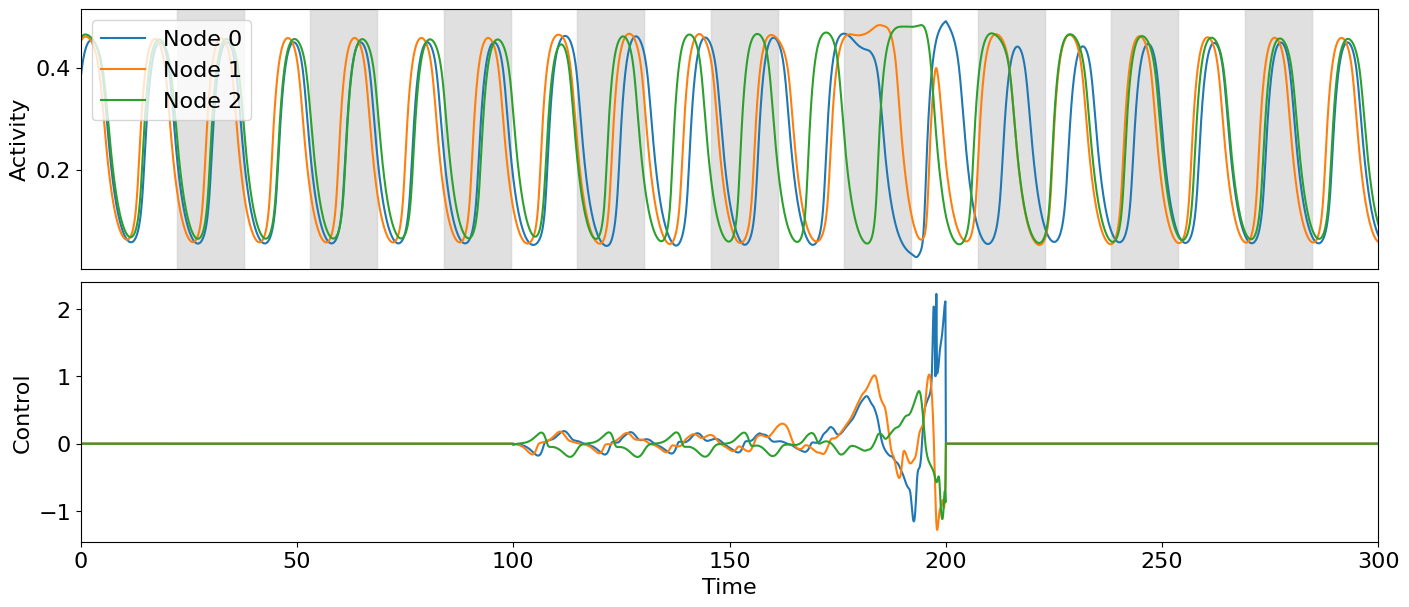

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.322134763023482
Converged in iteration 6 with cost -0.45849299608140304
Final cost : -0.45849299608140304


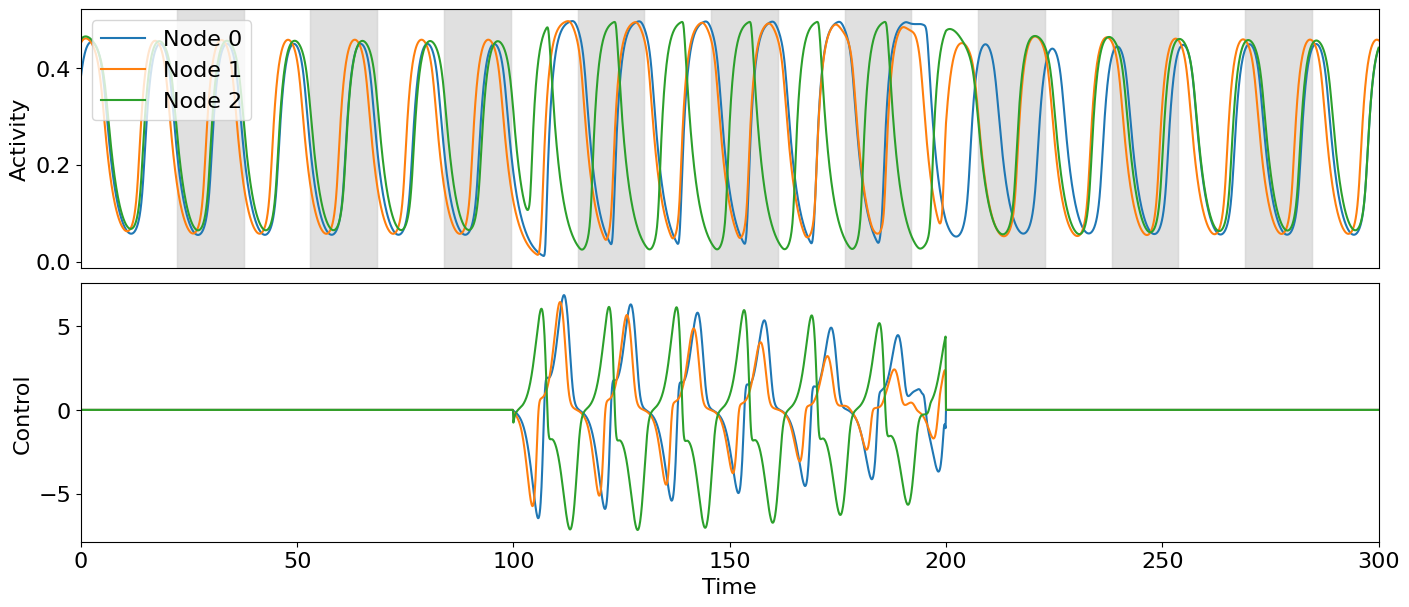

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.2608555780482714
Converged in iteration 3 with cost -0.4945969050004936
Final cost : -0.4945969050004936


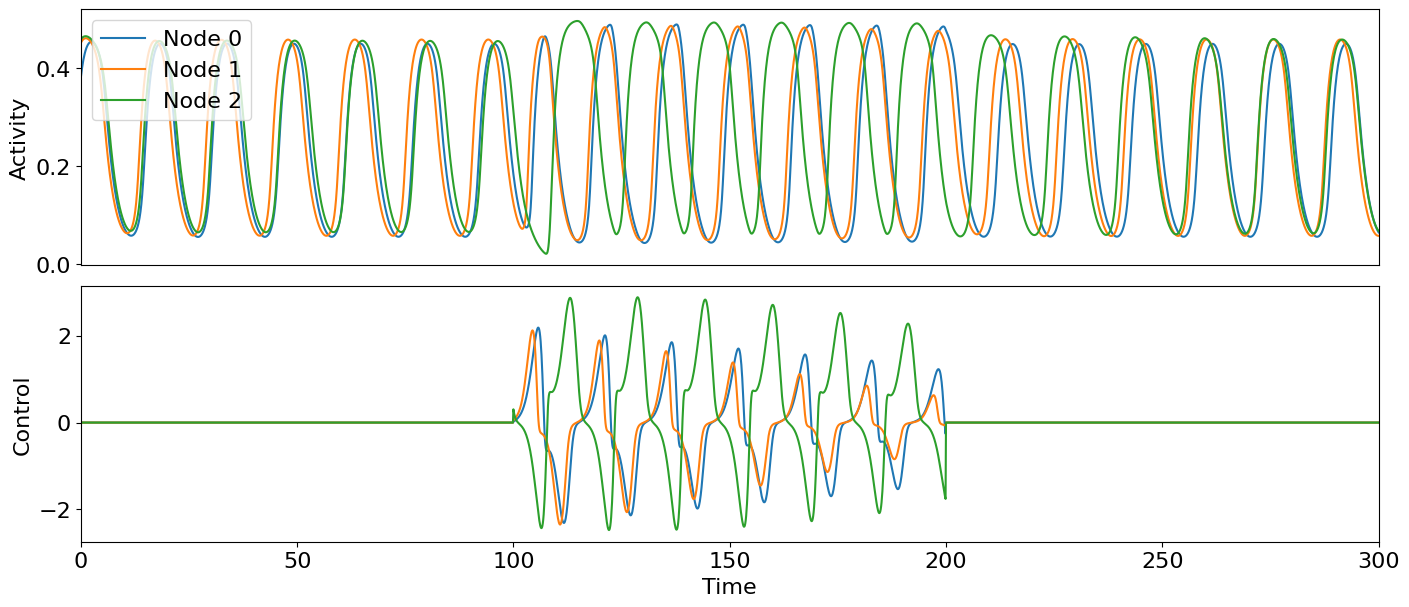

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.2608555780482714
Converged in iteration 3 with cost -0.6087927192731694
Final cost : -0.6087927192731694


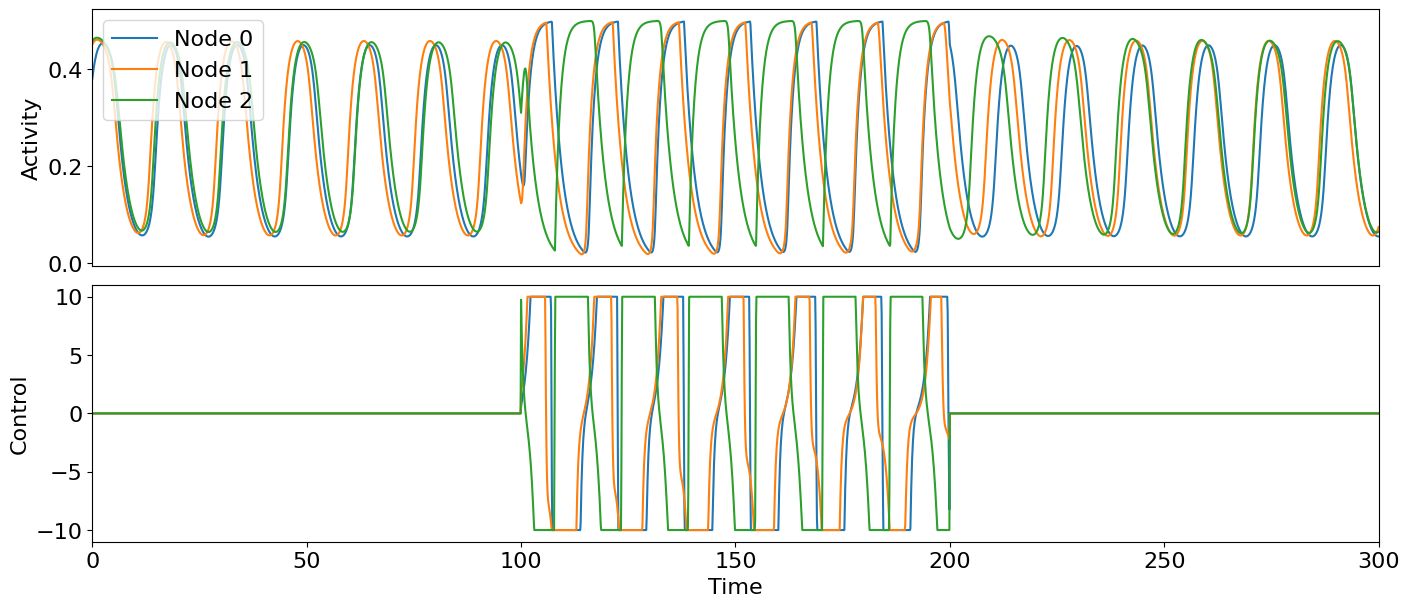

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -790.4910840670844
Converged in iteration 3 with cost -874.652144531951
Final cost : -874.652144531951


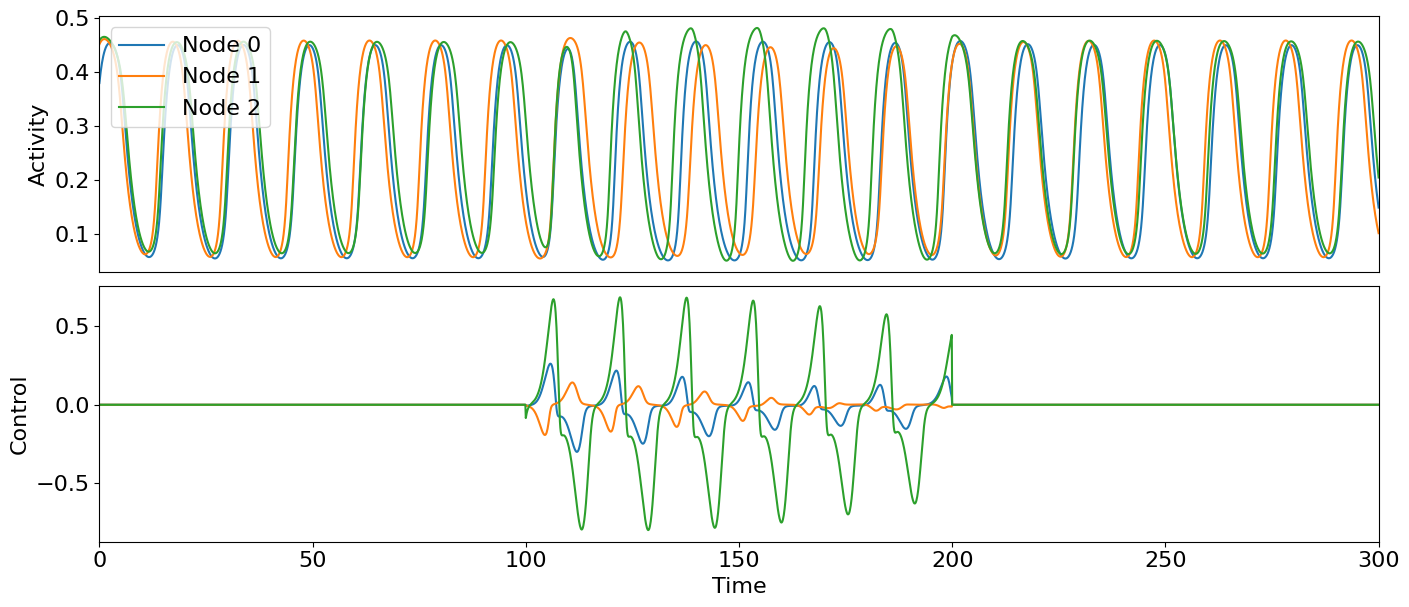

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -790.4910840670844
Converged in iteration 3 with cost -874.6603681901771
Final cost : -874.6603681901771


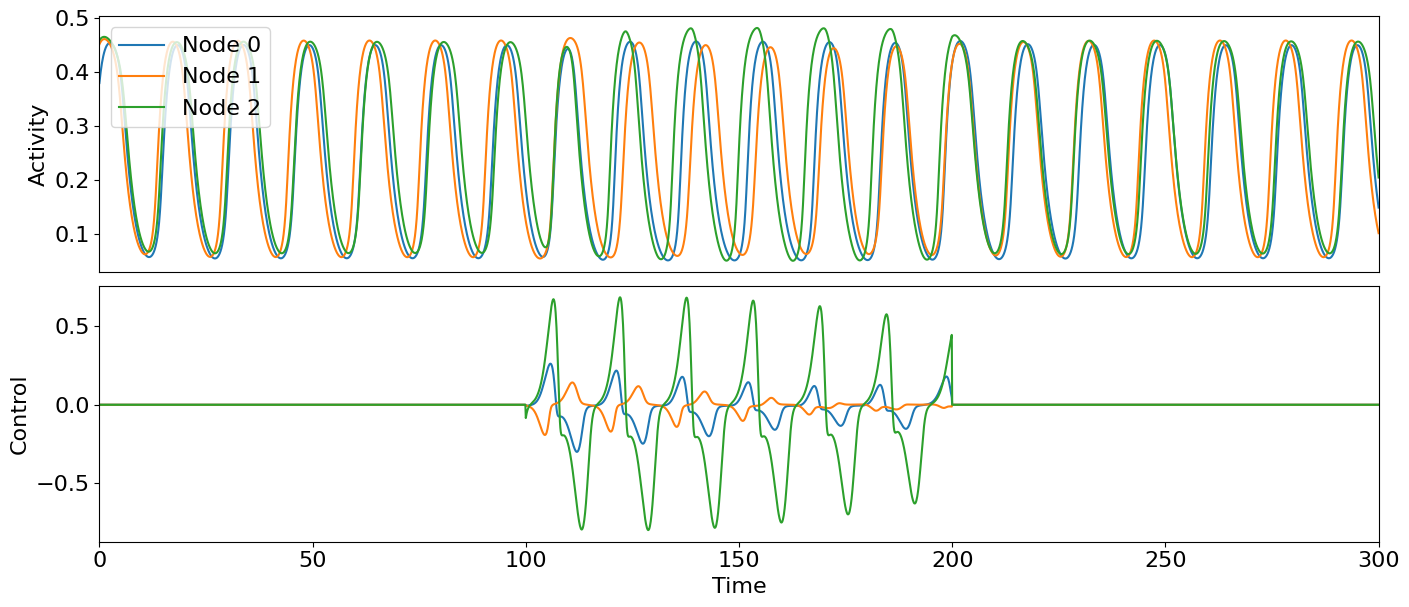

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.8316198402717438
Cost in iteration 10: 0.19835100360184207
Cost in iteration 20: 0.12850622232209757
Cost in iteration 30: 0.09838000012045545
Cost in iteration 40: 0.09225504683121523
Cost in iteration 50: 0.08780392631407566
Cost in iteration 60: 0.08200497805121046
Cost in iteration 70: 0.07584094042968945
Converged in iteration 78 with cost 0.07375169959943895
Final cost : 0.07375169959943895


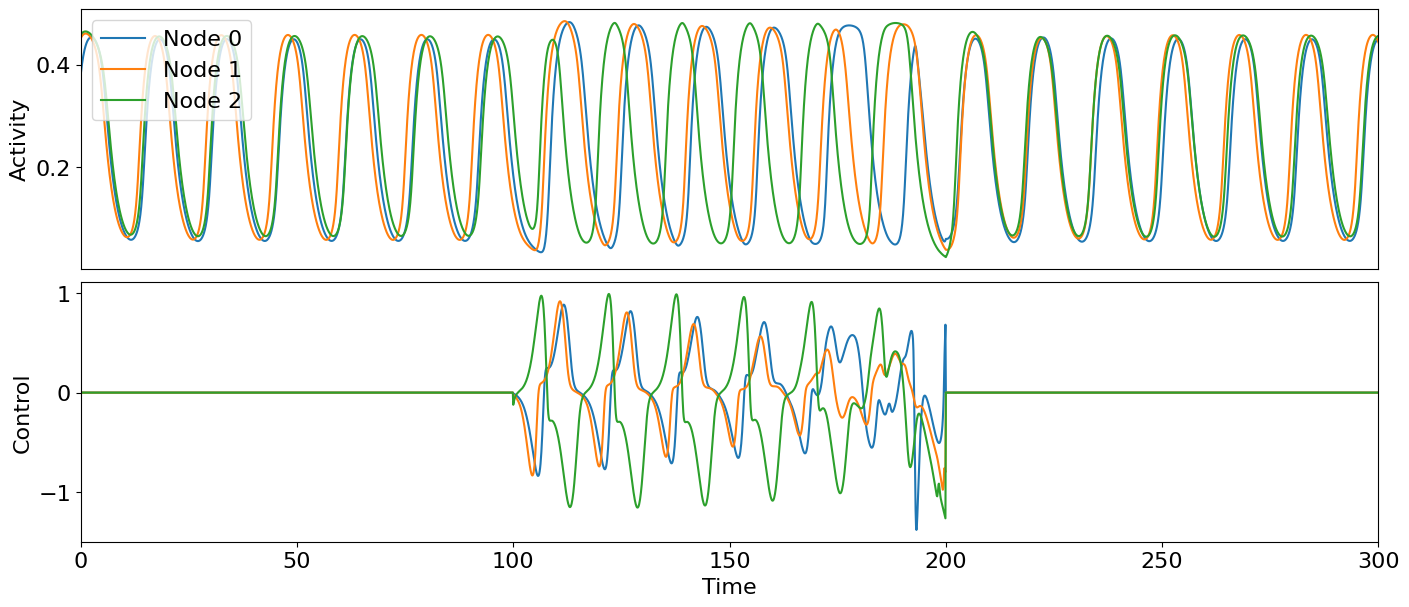

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.8316198402717438
Converged in iteration 5 with cost 0.13973113074689258
Final cost : 0.13973113074689258


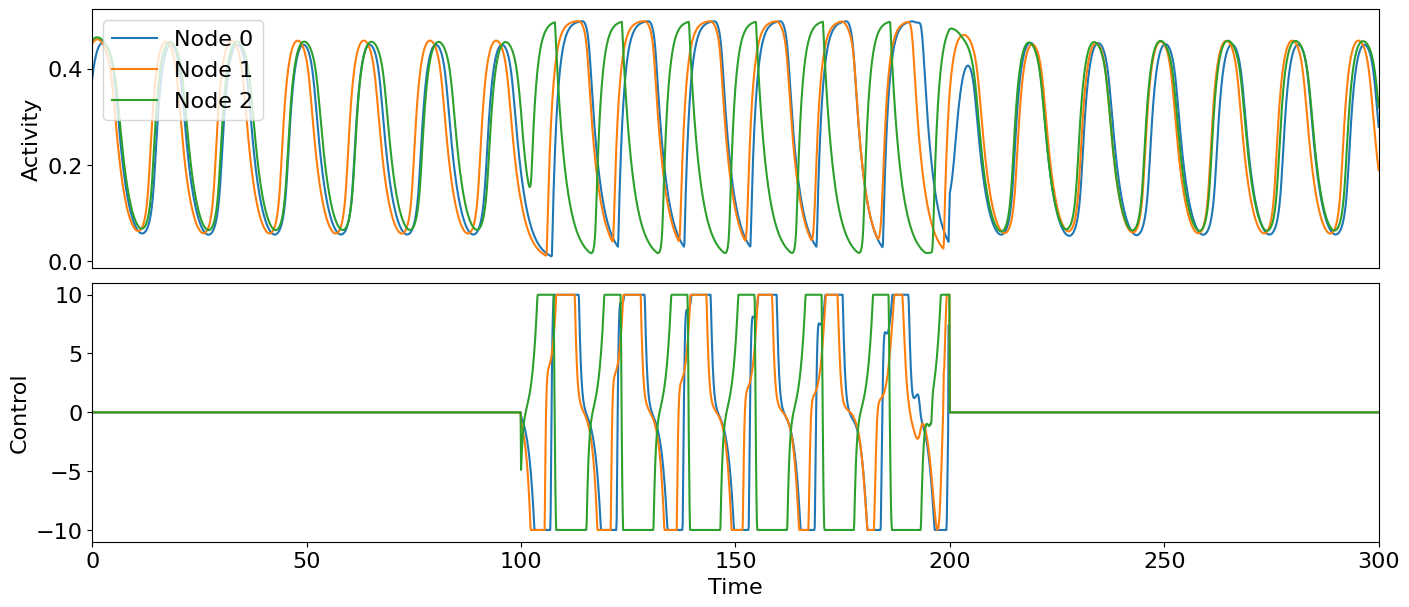

In [52]:
for pind in range(len(comp_points)):

    if pind != 2:
        continue

    p = comp_points[pind]
    
    testd = 1000.
    model.params.duration = testd
    test_input = ZeroInput().generate_input(duration=testd+model.params.dt, dt=model.params.dt)
    model.params["exc_ext"] = test_input + p[0]
    model.params["inh_ext"] = test_input + p[1]
    model.run()

    einit = np.zeros((N, nmaxdel+1))
    iinit = np.zeros((N, nmaxdel+1))


    for n in range(N):
        einit[n,:] = model.exc[n,-1]
        iinit[n,:] = model.inh[n,-1]

    model.params.duration = duration

    model.params["exc_ext"] = zero_control[:,0,:] + p[0]
    model.params["inh_ext"] = zero_control[:,0,:] + p[1]

    model.params["exc_init"] = einit
    model.params["inh_init"] = iinit

    model.run()

    for itar in range(len(target_array)):

        if itar != 2:
            continue

        target_period = target_array[itar]
        int0 = 2000
        int1 = 1000

        for imet in range(4):

            for iw in range(len(w2_array)):
                
                w2 = w2_array[iw]

                model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_interval=(int1,int0), cost_matrix=costmat, control_matrix = controlmat)
                model_controlled.maximum_control_strength = maxstr
                model_controlled.weights["w_p"] = 0.
                model_controlled.weights["w_2"] = w2

                if imet in [2]:
                    init_control = zero_control.copy()
                    tarray = np.arange(int0*dt, int0*dt + 2.*target_period, dt)
                    init_control[0,0,int0:int0+len(tarray)] = np.sin(2.*np.pi *tarray/target_period)
                    init_control[0,1,int0:int0+len(tarray)] = np.sin(2.*np.pi *tarray/target_period)

                    model_controlled.control = init_control.copy()
                    model_controlled.update_input()

                if imet == 0:
                    model_controlled.weights["w_f_sync"] = 1.
                elif imet == 1:
                    model_controlled.weights["w_cc"] = 1.
                elif imet == 2:
                    model_controlled.weights["w_ko"] = 1.
                elif imet == 3:
                    model_controlled.weights["w_var"] = 1.

                if type(results["controls"][pind][itar][imet][iw]) != type(None):
                    model_controlled.control = results["controls"][pind][itar][imet][iw].copy()
                    model_controlled.update_input()

                model_controlled.optimize(it)
                results["controls"][pind][itar][imet][iw] = model_controlled.control.copy()

                timings, periods = getperiods(model_controlled.get_xs(), proms[iw], int0=int0)
                results["timings"][pind][itar][imet][iw] = timings
                results["periods"][pind][itar][imet][iw] = periods

                fname = str(pind) + "_" + str(itar) + "_" + str(imet) + "_" + str(iw) + ".png"

                if imet == 0: plot_oc_nw(N, duration, dt, model_controlled.get_xs(), target_period, model_controlled.control, filename= os.path.join(dir, fname))
                else: plot_oc_nw(N, duration, dt, model_controlled.get_xs(), 200, model_controlled.control, filename= os.path.join(dir, fname))

In [53]:
with open('snych_3n.pickle', 'wb') as f:
    pickle.dump(results, f)

In [6]:
with open('snych_3n.pickle', 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

results = res_read.copy()

dict_keys(['controls', 'periods', 'timings'])


In [54]:
xl = [ ["Down F", "Up F", "Osc F"], ["Down CC", "Up CC", "Osc CC"], ["Down KO", "Up KO", "Osc KO"], ["Down Var", "Up Var", "Osc Var"]]

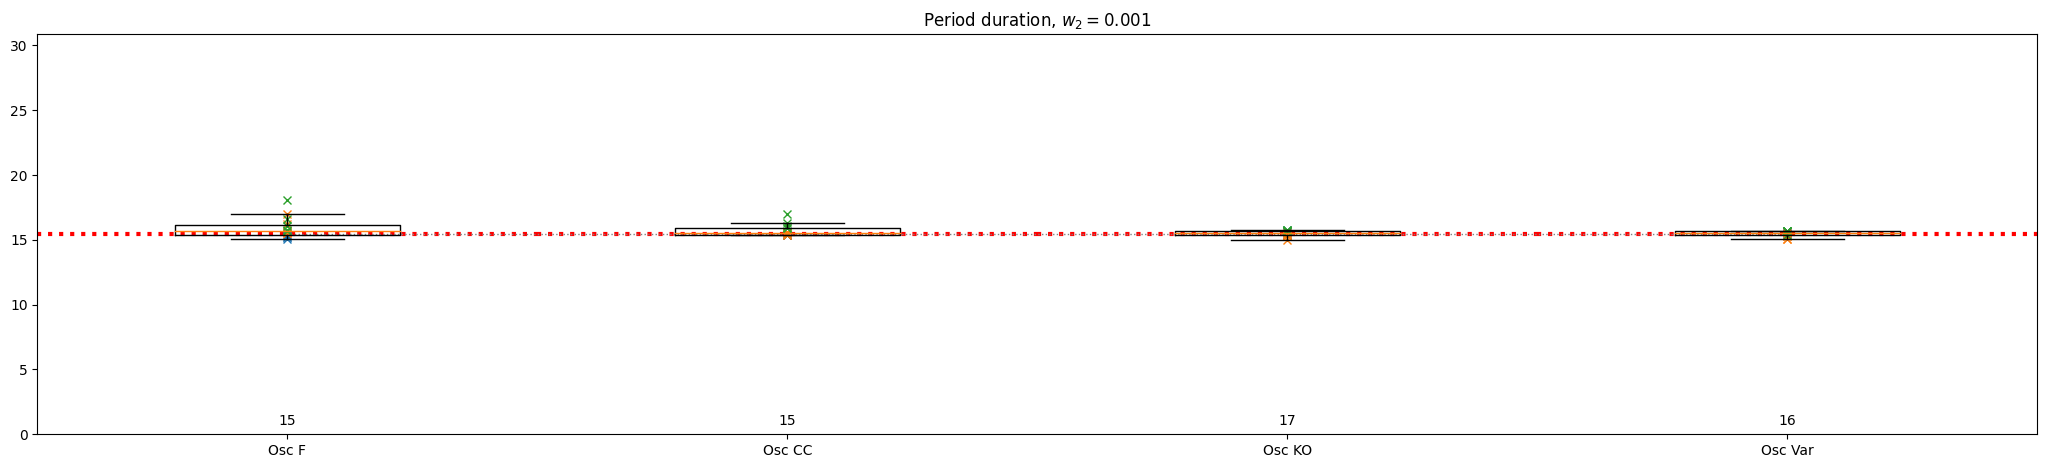

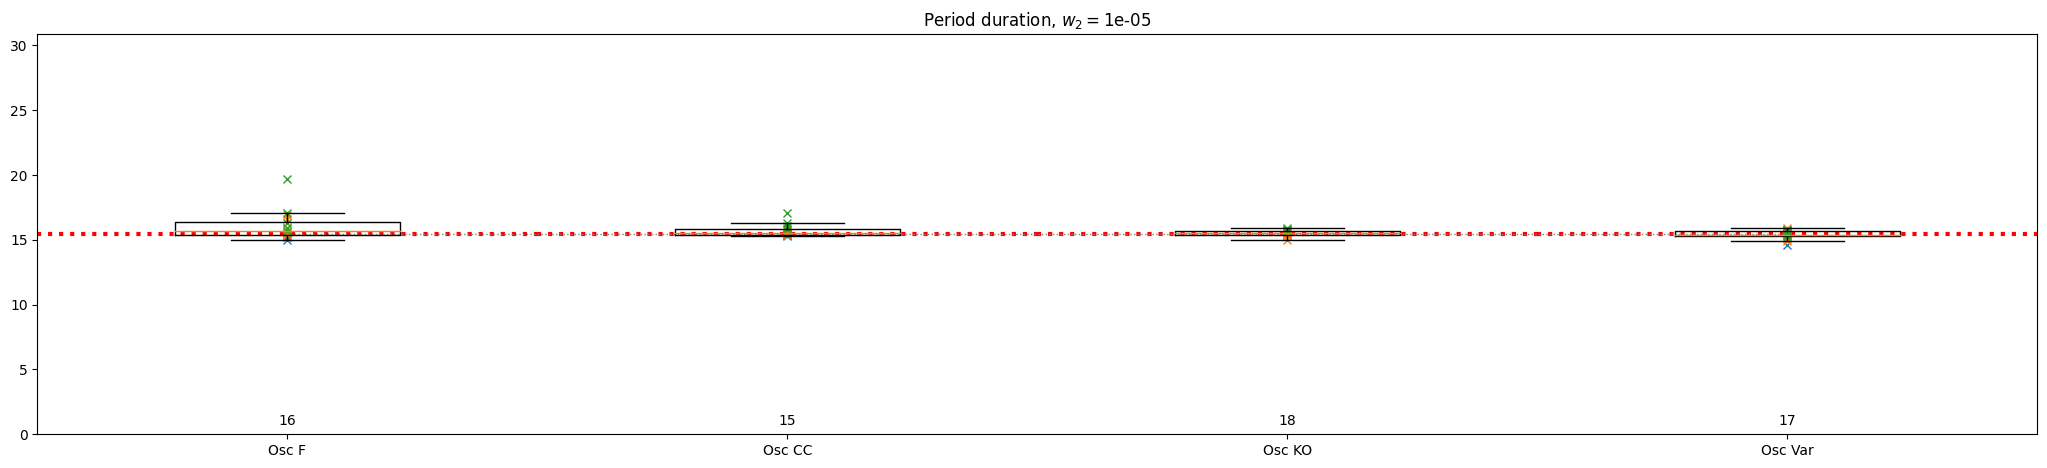

In [55]:
for iw in range(len(w2_array)):
    ydata = []
    xlabels = []
    fig = plt.figure(figsize =(20, 4))
    ax = fig.add_axes([0, 0, 1, 1])

    xpos = 0

    for imet in range(4):

        for pind in range(len(comp_points)):

            if pind != 2:
                continue

            for itar in range(len(target_array)):

                if itar != 2:
                    continue

                target_period = target_array[itar]
                #xpos = 15*imet + 5*pind + itar 

                if imet in [0]:
                    #if itar != 0:
                    #    xlabels.append("")
                    #else:
                    xlabels.append(xl[imet][pind])
                else:
                    xlabels.append(xl[imet][pind])

                data = results["periods"][pind][itar][imet][iw]
                ydata_ = []
                
                if data is None:
                    ydata.append(ydata_)
                    xpos += 1
                    continue

                n_datapoints = 0

                for n in range(N):
                    n_datapoints += len(data[n])
                    
                    if len(data[n]) != 0:
                        for dpoint in data[n]:
                            ax.plot(xpos+1, dpoint, marker="x", color=colors[n])
                            ydata_.append(dpoint)

                ydata.append(ydata_)

                ax.text(xpos+1, 1, str(n_datapoints), horizontalalignment='center', verticalalignment='center')
                if xpos < 15: ax.hlines(target_period, xpos+0.5, xpos+1.5, linestyle=":", color="red", linewidth =3)

                xpos += 1


    ax.boxplot(ydata, showfliers=False)
    ax.plot()
    ax.hlines(period, 1., len(xlabels), linestyle=":", color="grey",linewidth = 1)
    ax.set_xticklabels(xlabels)
    ax.set_ylim(0., 2.*period)
    ax.set_title(r"Period duration, $w_2 = $" + "{}".format(w2_array[iw]))
    plt.show()
    fig.savefig(os.path.join(dir, "periods_" + str(iw) + ".png"), bbox_inches='tight')

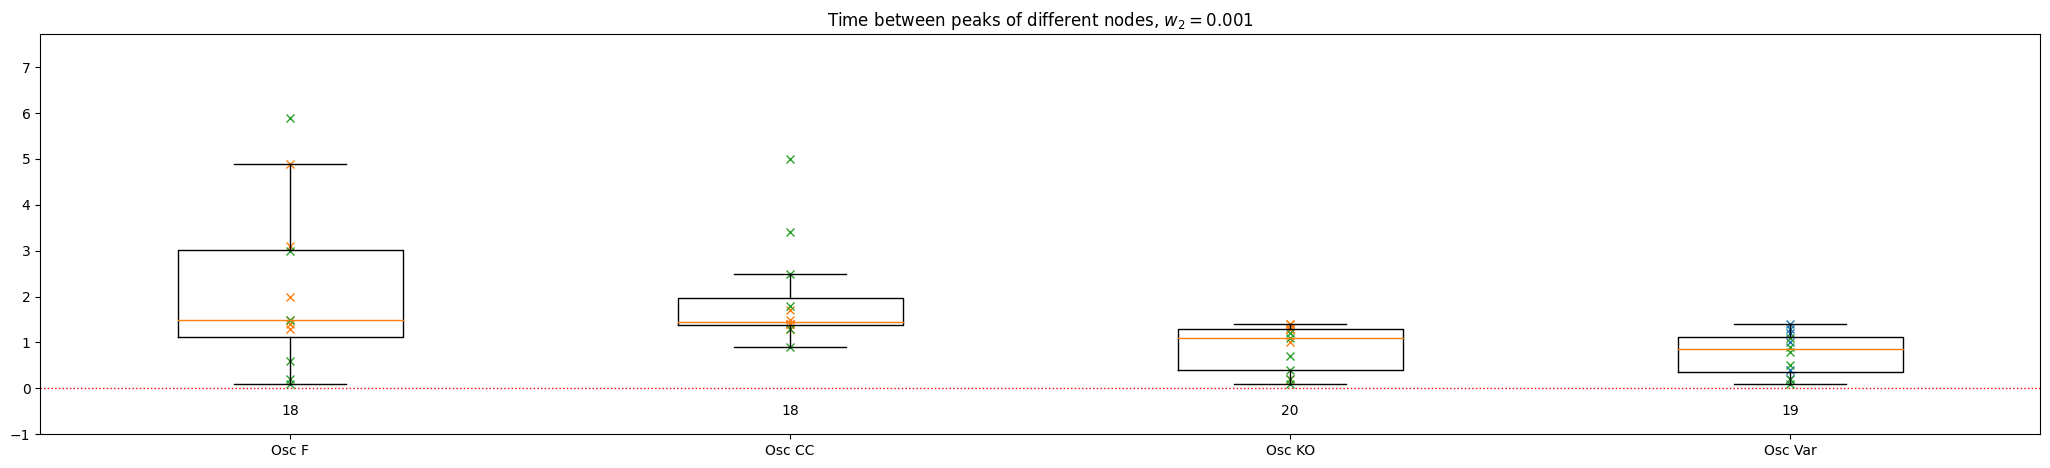

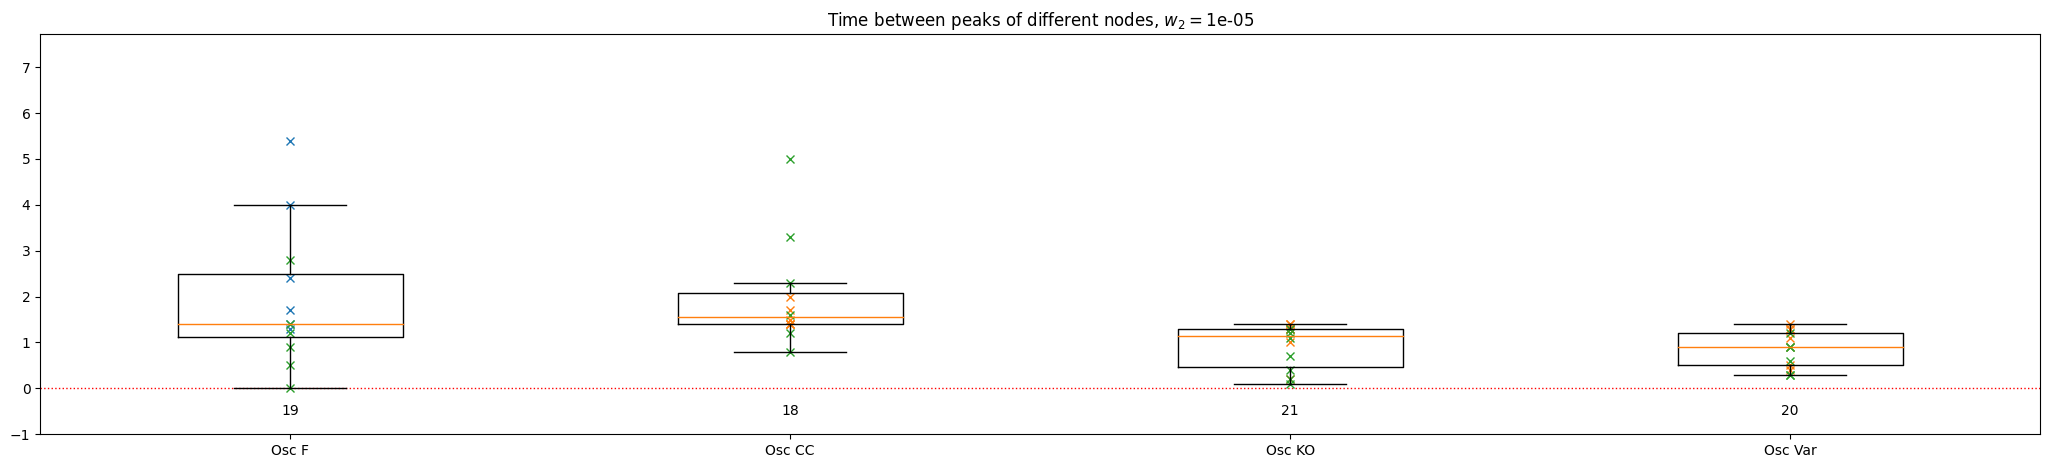

In [56]:
for iw in range(len(w2_array)):
    ydata = []
    xlabels = []
    fig = plt.figure(figsize =(20, 4))
    ax = fig.add_axes([0, 0, 1, 1])
    xpos = 0

    for imet in range(4):

        for pind in range(len(comp_points)):

            if pind != 2:
                continue

            for itar in range(len(target_array)):

                if itar != 2:
                    continue

                if imet in [0]:
                    #if itar != 0:
                    #    xlabels.append("")
                    #else:
                    xlabels.append(xl[imet][pind])
                else:
                    xlabels.append(xl[imet][pind])

                data = results["timings"][pind][itar][imet][iw]
                ydata_ = []

                if data is None:
                    ydata.append(ydata_)
                    xpos += 1
                    continue

                n_maxpeaks = 0

                for n in range(1, N):
                    if len(data[n]) > len(data[n_maxpeaks]):
                        n_maxpeaks = n

                n_datapoints = 0

                for n in range(N):
                    n_datapoints += len(data[n])
                    if n == n_maxpeaks:
                        continue
                    for p in data[n]:
                        dpoint = np.amin(np.abs(p - data[n_maxpeaks])) * dt
                        ydata_.append( dpoint )
                        ax.plot(xpos+1, dpoint, marker="x", color=colors[n])
                ax.text(xpos+1, -0.5, str(n_datapoints), horizontalalignment='center', verticalalignment='center')

                ydata.append(ydata_)

                xpos += 1

    ax.boxplot(ydata, showfliers=False)
    ax.plot()
    ax.hlines(0., 0.5, len(xlabels)+0.5, linestyle=":", color="red",linewidth = 1)
    ax.set_xticklabels(xlabels)
    ax.set_ylim(-1., 0.5*period)
    ax.set_title(r"Time between peaks of different nodes, $w_2 = $" + "{}".format(w2_array[iw]))
    plt.show()
    fig.savefig(os.path.join(dir, "timings_" + str(iw) + ".png"), bbox_inches='tight')